In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

import warnings
warnings.filterwarnings("ignore")

# Demo for "Entropies and Mutual Informations in Models of Deep Neural Networks"

In this notebook we demonstrate how to compute entropies and mutual informations using the `dnner` package. Let us start by importing `dnner` and some of the possible activations (`ReLU`, `HardTanh`) and priors (`Normal`). We also gonna use the ensemble `Empirical` which allows the computation for arbitrary finite-size spectra.

In [2]:
import dnner
from dnner.activations import ReLU, HardTanh
from dnner.priors import Normal
from dnner.ensembles import Empirical

The main function to be used is `dnner.compute_entropy`, which take as arguments `layers` and `weights`; `layers` is a list consisting of one prior and an arbitrary number of activations, for instance

In [3]:
layers = [Normal(0, 1), ReLU(0), HardTanh(1e-5)]

The arguments of the first entry give the parameters of the prior distribution (in this case a Normal distribution of zero mean and unit variance), whereas the remaining are related to the noise injected at each layer for the computation -- this noise is typically needed to make sure the entropy/mutual information does not diverge.

We then define `weights` using 2D arrays of arbitrary size -- the larger the better, as our scheme assumes large sizes. Let's assume for this example that both layers consist of random Gaussian weights of size $N \times N$ and variance $1/N$, $N = 1000$

In [4]:
np.random.seed(42)
W1 = np.random.randn(1000, 1000) / np.sqrt(1000)
W2 = np.random.randn(1000, 1000) / np.sqrt(1000)
weights = [W1, W2]

After defining them, we can just run

In [5]:
dnner.compute_entropy(layers, weights)

-0.7916758921010114

So for this choice of model and weights, we get $\lim_{N_X \to \infty} N_X^{-1} H ({\bf Y} | W_1, W_2) = -0.7916...$

If we want to have a better grasp of what is going on, we can use the `verbose = 1` argument, which shows the output of the iteration used to extremize $\phi ({\bf A}, {\bf V}, {\bf {\tilde A}}, {\bf {\tilde V}})$.

In [6]:
dnner.compute_entropy(layers, weights, verbose=1)

t = 0, conv = 2.35209e-05
layer 0: a = 42158.6, v_in = 9.99708e-11, a_in = 42514.3, v = 2.3521e-05
layer 1: a = 84206.1, v_in = 1.00175e-10, a_in = 84317.9, v = 4.9985e-11
got entropy = 1.46491 starting from v0 = [1e-10, 1e-10]
t = 0, conv = 0.449527
layer 0: a = 0.81564, v_in = 0.999708, a_in = 0.816598, v = 0.550479
layer 1: a = 84206.1, v_in = 1.00175e-10, a_in = 84317.9, v = 6.07879e-06
t = 1, conv = 0.12606
layer 0: a = 1.35583, v_in = 0.550328, a_in = 1.35614, v = 0.424423
layer 1: a = 52337.5, v_in = 6.08914e-06, a_in = 52450.6, v = 9.84711e-06
t = 2, conv = 0.0531025
layer 0: a = 1.693, v_in = 0.424301, a_in = 1.69307, v = 0.371323
layer 1: a = 42391.9, v_in = 9.86375e-06, a_in = 42475.2, v = 1.21802e-05
t = 3, conv = 0.0263374
layer 0: a = 1.89871, v_in = 0.371235, a_in = 1.89866, v = 0.344987
layer 1: a = 37929.4, v_in = 1.22007e-05, a_in = 37999.5, v = 1.36272e-05
t = 4, conv = 0.0141524
layer 0: a = 2.02277, v_in = 0.344922, a_in = 2.02265, v = 0.330835
layer 1: a = 35604.7

t = 16, conv = 1.12322e-07
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32373, v_in = 1.60111e-05, a_in = 32427.5, v = 1.59842e-05
t = 17, conv = 6.49405e-08
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32372.9, v_in = 1.60111e-05, a_in = 32427.4, v = 1.59843e-05
t = 18, conv = 3.76702e-08
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32372.9, v_in = 1.60112e-05, a_in = 32427.4, v = 1.59843e-05
t = 19, conv = 2.19275e-08
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32372.9, v_in = 1.60112e-05, a_in = 32427.3, v = 1.59843e-05
t = 20, conv = 1.28109e-08
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32372.9, v_in = 1.60112e-05, a_in = 32427.3, v = 1.59843e-05
t = 21, conv = 7.51385e-09
layer 0: a = 2.20669, v_in = 0.311839, a_in = 2.20648, v = 0.311868
layer 1: a = 32372.9, v_in = 1.60112e-05, a_in = 32427.3, v = 

-0.7916758921010114

## Entropies at initialization: reproducing Figure 2

Let's set up an experiment to see how the entropy changes as a function of the weight scaling. We first write a function which takes an arbitrary choice of layers

In [7]:
def run_experiment(layers, weight_stds):
    """Tries different weight variances for fixed layers"""

    n_layers = len(layers) - 1

    # Generate (unscaled) weights
    weights_orig = []
    for i in range(n_layers):
        w = np.random.randn(1000, 1000) / np.sqrt(1000)
        weights_orig.append(w)

    # Loop through weight variances
    entropies = np.empty(len(weight_stds))
    for i, sigma in enumerate(weight_stds):
        print("sigma = ", sigma)
        weights = [sigma * w for w in weights_orig]
        entropies[i] = dnner.compute_entropy(layers=layers, weights=weights, verbose=0)

    return entropies

and then run it for two different choices, ReLU-ReLU and hardtanh-hardtanh

In [8]:
# Parameters
weight_stds = np.logspace(-1, 1, 5)
var_noise = 1e-5

# Run experiment w/ ReLU
print("Running experiment w/ ReLU...")
layers1 = [Normal(0, 1), ReLU(0), ReLU(var_noise)]
es1 = run_experiment(layers1, weight_stds)

# Run experiment w/ HardTanh
print("\nRunning experiment w/ hardtanh...")
layers2 = [Normal(0, 1), HardTanh(0), HardTanh(var_noise)]
es2 = run_experiment(layers2, weight_stds)

Running experiment w/ ReLU...
sigma =  0.1
sigma =  0.31622776601683794
sigma =  1.0
sigma =  3.1622776601683795
sigma =  10.0

Running experiment w/ hardtanh...
sigma =  0.1
sigma =  0.31622776601683794
sigma =  1.0
sigma =  3.1622776601683795
sigma =  10.0


Finally we plot the results, adding the entropy of linear activations for reference for the hardtanh. Notice this is the same we get in Figure 2 of our paper (left bottom and center bottom respectively).

In [9]:
# Generate Gaussian random matrices and compute singular values of the product
W1 = np.random.randn(1000, 1000) / np.sqrt(1000)
W2 = np.random.randn(1000, 1000) / np.sqrt(1000)
W = W1 @ W2
s = np.linalg.svd(W, compute_uv=False)

# Compute entropy of linear activation
s_scaled = np.outer(s, weight_stds ** 2)
linear_es = .5 * np.mean(np.log(var_noise + s_scaled ** 2), 0) + .5 * np.log(2 * np.pi * np.e)

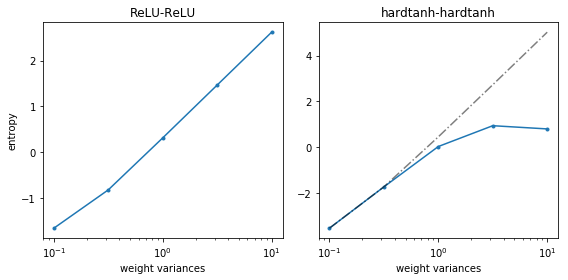

In [10]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

axs[0].semilogx(weight_stds, es1, ".-")
axs[0].set_ylabel("entropy")
axs[0].set_xlabel("weight variances")
axs[0].set_title("ReLU-ReLU")

axs[1].semilogx(weight_stds, es2, ".-")
axs[1].set_xlabel("weight variances")
axs[1].set_title("hardtanh-hardtanh")
axs[1].semilogx(weight_stds, linear_es, "k-.", alpha=0.5)

fig.set_tight_layout(True)